# Traveling Salesman Problem - Baja California 

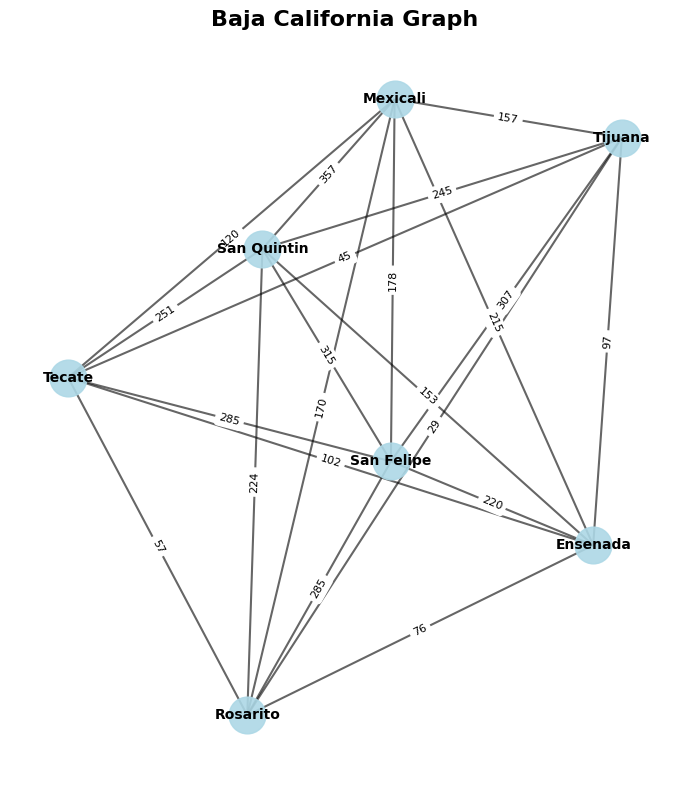

In [110]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

bc_matrix = pd.read_csv('../bc_tsp_matrix.csv', index_col=0)

city_mapping = {
    'Tijuana, Baja California, Mexico': 'Tijuana',
    'Mexicali, Baja California, Mexico': 'Mexicali',
    'Ensenada, Baja California, Mexico': 'Ensenada',
    'Tecate, Baja California, Mexico': 'Tecate',
    'Rosarito, Baja California, Mexico': 'Rosarito',
    'San Quintin, Baja California, Mexico': 'San Quintin',
    'San Felipe, Baja California, Mexico': 'San Felipe'
}

bc_matrix.rename(index=city_mapping, columns=city_mapping, inplace=True)

graph = {}
for city1 in bc_matrix.index:
    graph[city1] = []
    for city2 in bc_matrix.columns:
        if city1 != city2:
            tiempo = bc_matrix.loc[city1, city2]
            graph[city1].append((city2, tiempo))

G = nx.Graph()
for city1 in bc_matrix.index:
    for city2 in bc_matrix.columns:
        if city1 != city2:
            tiempo = bc_matrix.loc[city1, city2]
            G.add_edge(city1, city2, weight=tiempo)

plt.figure(figsize=(7, 8))
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

plt.title('Baja California Graph', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [111]:
def show_tsp_path(G, tsp_path, title="TSP Path Visualization"):
    plt.figure(figsize=(7, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, edge_color='gray')
    
    tsp_edges = [(tsp_path[i], tsp_path[i+1]) for i in range(len(tsp_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=tsp_edges, width=3, alpha=0.8, edge_color='red', arrows=True, arrowsize=20)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    tsp_edge_labels = {}
    for i in range(len(tsp_path)-1):
        edge = (tsp_path[i], tsp_path[i+1])
        if G.has_edge(edge[0], edge[1]):
            tsp_edge_labels[edge] = G[edge[0]][edge[1]]['weight']
    
    nx.draw_networkx_edge_labels(G, pos, tsp_edge_labels, font_size=9, font_color='red', font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Christofides Algorithm

In [112]:
import heapq

def minimum_spanning_tree(graph, start_node):
    mst_edges = []
    visited = {start_node}
    edges = [(cost, start_node, to) for to, cost in graph[start_node]]
    heapq.heapify(edges)

    while edges:
        cost, frm, to = heapq.heappop(edges)
        if to not in visited:
            visited.add(to)
            mst_edges.append((frm, to, cost))
            for next_to, next_cost in graph[to]:
                if next_to not in visited:
                    heapq.heappush(edges, (next_cost, to, next_to))
    return mst_edges


In [113]:
def minimum_weight_perfect_matching(graph, odd_nodes):
    if len(odd_nodes) == 0:
        return []
    if len(odd_nodes) == 2:
        return [(odd_nodes[0], odd_nodes[1])]
    
    matchings = []
    first_node = odd_nodes[0]
    for i in range(1, len(odd_nodes)):
        pair = (first_node, odd_nodes[i])
        remaining = odd_nodes[1:i] + odd_nodes[i+1:]
        sub_matching = minimum_weight_perfect_matching(graph, remaining)
        matchings.append([pair] + sub_matching)
    
    min_cost = float('inf')
    best_matching = None
    
    for matching in matchings:
        cost = 0
        for node1, node2 in matching:
            for neighbor, weight in graph[node1]:
                if neighbor == node2:
                    cost += weight
                    break
        
        if cost < min_cost:
            min_cost = cost
            best_matching = matching
    
    return best_matching

In [114]:
from collections import defaultdict

def find_eulerian_circuit(edges, start_node):
    
    adj = defaultdict(list)
    for u, v, weight in edges:
        adj[u].append(v)
        adj[v].append(u)

    circuit = []
    stack = [start_node]
    current_path = []
    
    while stack:
        curr = stack[-1]
        if adj[curr]:
            next_node = adj[curr].pop()
            adj[next_node].remove(curr)
            stack.append(next_node)
        else:
            current_path.append(stack.pop())
    
    return current_path[::-1]

In [115]:
def make_hamiltonian_cycle(eulerian_circuit):
    visited = set()
    hamiltonian_cycle = []
    
    for node in eulerian_circuit:
        if node not in visited:
            visited.add(node)
            hamiltonian_cycle.append(node)
    
    if hamiltonian_cycle and hamiltonian_cycle[0] != hamiltonian_cycle[-1]:
        hamiltonian_cycle.append(hamiltonian_cycle[0])
    
    return hamiltonian_cycle

In [116]:
def calculate_path_cost(graph, path):
    total_cost = 0
    for i in range(len(path) - 1):
        node1, node2 = path[i], path[i + 1]
        for neighbor, weight in graph[node1]:
            if neighbor == node2:
                total_cost += weight
                break
    return total_cost

In [117]:
def christofides_algorithm(graph, start_node='Tijuana'):
    mst_path = minimum_spanning_tree(graph, start_node)
    print(f"MST Path: {mst_path}")

    degree = {}
    for frm, to, cost in mst_path:
        degree[frm] = degree.get(frm, 0) + 1
        degree[to] = degree.get(to, 0) + 1
    
    odd_degree_nodes = [node for node, deg in degree.items() if deg % 2]

    perfect_matching = minimum_weight_perfect_matching(graph, odd_degree_nodes)
    print(f"Perfect Matching: {perfect_matching}")

    eulerian_graph = mst_path.copy()
    for node1, node2 in perfect_matching:
        for neighbor, weight in graph[node1]:
            if neighbor == node2:
                eulerian_graph.append((node1, node2, weight))
                break
    print(f"Eulerian Graph: {eulerian_graph}")

    eulerian_circuit = find_eulerian_circuit(eulerian_graph, start_node)
    print(f"Eulerian Circuit: {eulerian_circuit}")

    tsp_path = make_hamiltonian_cycle(eulerian_circuit)

    tsp_cost = calculate_path_cost(graph, tsp_path)

    return tsp_path, tsp_cost

tsp_path, tsp_cost = christofides_algorithm(graph)
print(f"TSP Path: {tsp_path}")
print(f"TSP Cost (hrs): {tsp_cost / 60}")

MST Path: [('Tijuana', 'Rosarito', np.int64(29)), ('Tijuana', 'Tecate', np.int64(45)), ('Rosarito', 'Ensenada', np.int64(76)), ('Tecate', 'Mexicali', np.int64(120)), ('Ensenada', 'San Quintin', np.int64(153)), ('Mexicali', 'San Felipe', np.int64(178))]
Perfect Matching: [('San Quintin', 'San Felipe')]
Eulerian Graph: [('Tijuana', 'Rosarito', np.int64(29)), ('Tijuana', 'Tecate', np.int64(45)), ('Rosarito', 'Ensenada', np.int64(76)), ('Tecate', 'Mexicali', np.int64(120)), ('Ensenada', 'San Quintin', np.int64(153)), ('Mexicali', 'San Felipe', np.int64(178)), ('San Quintin', 'San Felipe', np.int64(315))]
Eulerian Circuit: ['Tijuana', 'Tecate', 'Mexicali', 'San Felipe', 'San Quintin', 'Ensenada', 'Rosarito', 'Tijuana']
TSP Path: ['Tijuana', 'Tecate', 'Mexicali', 'San Felipe', 'San Quintin', 'Ensenada', 'Rosarito', 'Tijuana']
TSP Cost (hrs): 15.266666666666667


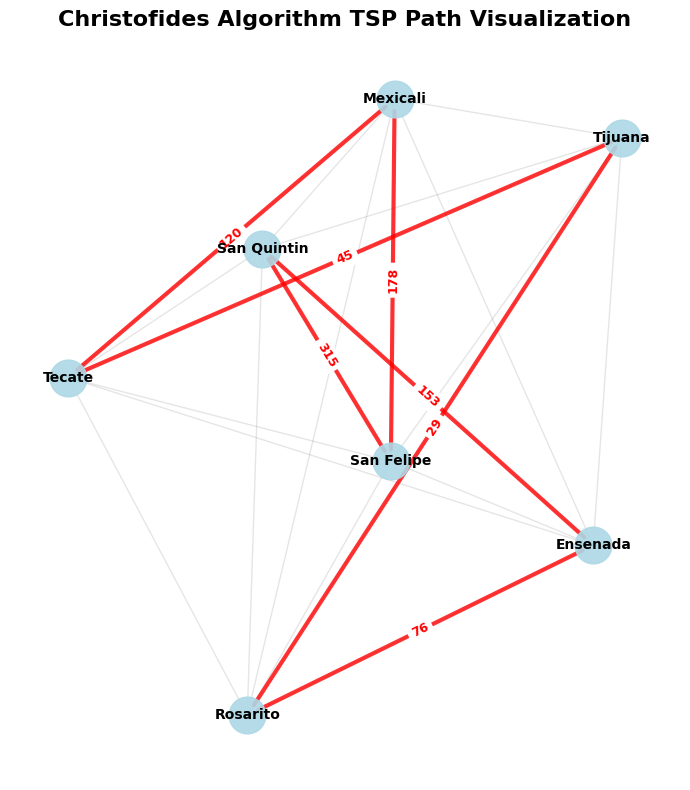

In [118]:
show_tsp_path(G, tsp_path, title="Christofides Algorithm TSP Path Visualization")

## Ant Colony Optimization

In [119]:
import numpy as np
import random

def ant_colony_optimization(graph, start_node, num_ants=10, num_iterations=50, alpha=1.0, beta=2.0, rho=0.5, Q=100):
    nodes = list(graph.keys())
    n_nodes = len(nodes)
    node_idx = {node: i for i, node in enumerate(nodes)}
    
    distances = np.zeros((n_nodes, n_nodes))
    for i, node1 in enumerate(nodes):
        for node2, cost in graph[node1]:
            j = node_idx[node2]
            distances[i, j] = cost
    
    pheromones = np.ones((n_nodes, n_nodes))
    heuristic = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and distances[i, j] > 0:
                heuristic[i, j] = 1.0 / distances[i, j]
    
    best_tour = None
    best_cost = float('inf')
    start_idx = node_idx[start_node]
    
    for iteration in range(num_iterations):
        for ant in range(num_ants):
            visited = [start_idx]
            while len(visited) < n_nodes:
                current = visited[-1]
                unvisited = [i for i in range(n_nodes) if i not in visited]
                probabilities = []
                for j in unvisited:
                    prob = (pheromones[current, j] ** alpha) * (heuristic[current, j] ** beta)
                    probabilities.append(prob)
                total_prob = sum(probabilities)
                if total_prob == 0:
                    next_node = random.choice(unvisited)
                else:
                    probabilities = [p/total_prob for p in probabilities]
                    next_node = random.choices(unvisited, weights=probabilities)[0]
                visited.append(next_node)
            visited.append(start_idx)
            tour_cost = sum(distances[visited[i], visited[i+1]] for i in range(n_nodes))
            if tour_cost < best_cost:
                best_cost = tour_cost
                best_tour = visited.copy()
        pheromones = (1 - rho) * pheromones
        for i in range(n_nodes):
            a, b = best_tour[i], best_tour[i+1]
            pheromones[a, b] += Q / best_cost
            pheromones[b, a] += Q / best_cost
    best_path = [nodes[i] for i in best_tour]
    return best_path, best_cost

tsp_path, tsp_cost = ant_colony_optimization(graph, start_node='Tijuana')
print('TSP Path:', tsp_path)
print('TSP Cost (hrs):', tsp_cost / 60)

TSP Path: ['Tijuana', 'Rosarito', 'Ensenada', 'San Quintin', 'San Felipe', 'Mexicali', 'Tecate', 'Tijuana']
TSP Cost (hrs): 15.266666666666667


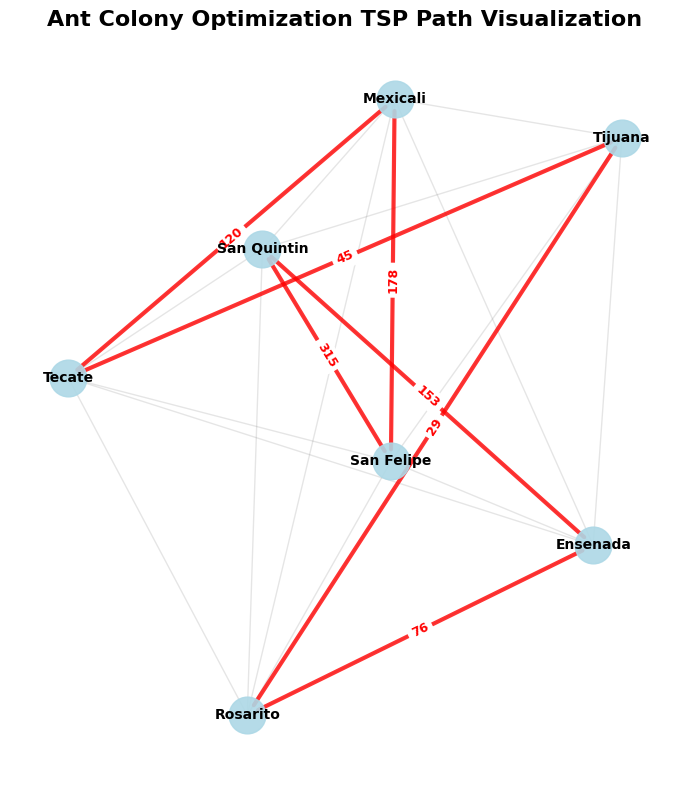

In [120]:
show_tsp_path(G, tsp_path, title="Ant Colony Optimization TSP Path Visualization")

In [121]:
import time

start_time = time.time()
tsp_path, tsp_cost = christofides_algorithm(graph, start_node='Tijuana')
end_time = time.time()
execution_time = end_time - start_time
print(f"Christofides Algorithm Execution Time: {execution_time:.4f} seconds")

start_time = time.time()
tsp_path, tsp_cost = ant_colony_optimization(graph, start_node='Tijuana')
end_time = time.time()
execution_time = end_time - start_time
print(f"Ant Colony Optimization Execution Time: {execution_time:.4f} seconds")

MST Path: [('Tijuana', 'Rosarito', np.int64(29)), ('Tijuana', 'Tecate', np.int64(45)), ('Rosarito', 'Ensenada', np.int64(76)), ('Tecate', 'Mexicali', np.int64(120)), ('Ensenada', 'San Quintin', np.int64(153)), ('Mexicali', 'San Felipe', np.int64(178))]
Perfect Matching: [('San Quintin', 'San Felipe')]
Eulerian Graph: [('Tijuana', 'Rosarito', np.int64(29)), ('Tijuana', 'Tecate', np.int64(45)), ('Rosarito', 'Ensenada', np.int64(76)), ('Tecate', 'Mexicali', np.int64(120)), ('Ensenada', 'San Quintin', np.int64(153)), ('Mexicali', 'San Felipe', np.int64(178)), ('San Quintin', 'San Felipe', np.int64(315))]
Eulerian Circuit: ['Tijuana', 'Tecate', 'Mexicali', 'San Felipe', 'San Quintin', 'Ensenada', 'Rosarito', 'Tijuana']
Christofides Algorithm Execution Time: 0.0010 seconds
Ant Colony Optimization Execution Time: 0.0349 seconds


### Testing 15 nodes

In [122]:
# Prueba con grafo sintético de 15 nodos (A-O) para Christofides y ACO
random.seed(42)
np.random.seed(42)

nodes_15 = [chr(ord('A') + i) for i in range(15)]
graph_15 = {node: [] for node in nodes_15}

# Grafo completo no dirigido con pesos simétricos
for i in range(len(nodes_15)):
    for j in range(i + 1, len(nodes_15)):
        w = random.randint(10, 200)
        u, v = nodes_15[i], nodes_15[j]
        graph_15[u].append((v, w))
        graph_15[v].append((u, w))

start_node_15 = 'A'

# Christofides
start_time = time.time()
tsp_path_ch, tsp_cost_ch = christofides_algorithm(graph_15, start_node=start_node_15)
end_time = time.time()
time_ch = end_time - start_time

# ACO
start_time = time.time()
tsp_path_aco, tsp_cost_aco = ant_colony_optimization(
    graph_15,
    start_node=start_node_15,
    num_ants=20,
    num_iterations=100,
    alpha=1.0,
    beta=2.0,
    rho=0.5,
    Q=100
)
end_time = time.time()
time_aco = end_time - start_time

print("=== Christofides ===")
print("Costo TSP:", tsp_cost_ch)
print("Ruta:", " -> ".join(tsp_path_ch))
print(f"Tiempo de ejecución: {time_ch:.6f} segundos\n")

print("=== Ant Colony Optimization (ACO) ===")
print("Costo TSP:", tsp_cost_aco)
print("Ruta:", " -> ".join(tsp_path_aco))
print(f"Tiempo de ejecución: {time_aco:.6f} segundos")

MST Path: [('A', 'D', 16), ('A', 'O', 32), ('O', 'F', 21), ('F', 'B', 17), ('B', 'L', 16), ('L', 'C', 11), ('B', 'E', 18), ('E', 'H', 21), ('F', 'N', 27), ('O', 'I', 28), ('B', 'G', 33), ('G', 'K', 30), ('D', 'M', 34), ('D', 'J', 36)]
Perfect Matching: [('D', 'K'), ('O', 'I'), ('F', 'N'), ('C', 'H'), ('M', 'J')]
Eulerian Graph: [('A', 'D', 16), ('A', 'O', 32), ('O', 'F', 21), ('F', 'B', 17), ('B', 'L', 16), ('L', 'C', 11), ('B', 'E', 18), ('E', 'H', 21), ('F', 'N', 27), ('O', 'I', 28), ('B', 'G', 33), ('G', 'K', 30), ('D', 'M', 34), ('D', 'J', 36), ('D', 'K', 33), ('O', 'I', 28), ('F', 'N', 27), ('C', 'H', 66), ('M', 'J', 53)]
Eulerian Circuit: ['A', 'O', 'I', 'O', 'F', 'N', 'F', 'B', 'E', 'H', 'C', 'L', 'B', 'G', 'K', 'D', 'J', 'M', 'D', 'A']
=== Christofides ===
Costo TSP: 851
Ruta: A -> O -> I -> F -> N -> B -> E -> H -> C -> L -> G -> K -> D -> J -> M -> A
Tiempo de ejecución: 0.005270 segundos

=== Ant Colony Optimization (ACO) ===
Costo TSP: 517.0
Ruta: A -> D -> J -> M -> C -> L